# Synthetic Audio–Video Pullback Alignment (In-class Demo)
We model **audio** and **video** observations as two objects mapping into a common object of **timestamps**.

- **A**: video frame embeddings $v_i$
- **B**: audio chunk embeddings $a_j$
- **C**: discrete time index $t \in \{0,\dots,T-1\}$

Maps:
- $f: A\to C$ predicts time from video
- $g: B\to C$ predicts time from audio

The **pullback** $P = A\times_C B$ is the aligned set of pairs $(v,a)$ that agree on time.

This notebook:
1. Generates a latent time series and synthetic audio/video embeddings.
2. Trains two classifiers $f,g$ to predict timestamps.
3. Builds the pullback alignment in two ways:
   - **Hard**: match by argmax timestamp
   - **Soft**: match by overlap of time distributions + Hungarian assignment
4. Evaluates alignment accuracy.


## 0) Setup

In [1]:
!pip -q install torch numpy scipy matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cuda


## 1) Generate synthetic multimodal data
We create a latent state $s_t$ for each time $t$, then generate:
- video embedding $v_t = W_v s_t + \epsilon$
- audio embedding $a_t = W_a s_t + \epsilon$

Finally, we **shuffle** video and audio independently, destroying alignment.


In [6]:
rng = np.random.default_rng(0)

T = 80          # time steps
d_s = 16        # latent dim
d_v = 48        # video embedding dim
d_a = 48        # audio embedding dim
noise_v = 0.35
noise_a = 0.35

S = rng.normal(size=(T, d_s)).astype(np.float32)
Wv = (rng.normal(size=(d_s, d_v)) / np.sqrt(d_s)).astype(np.float32)
Wa = (rng.normal(size=(d_s, d_a)) / np.sqrt(d_s)).astype(np.float32)

V = S @ Wv + noise_v * rng.normal(size=(T, d_v)).astype(np.float32)
A = S @ Wa + noise_a * rng.normal(size=(T, d_a)).astype(np.float32)

t_true = np.arange(T, dtype=np.int64)

perm_v = rng.permutation(T)
perm_a = rng.permutation(T)

V_shuf = V[perm_v]
A_shuf = A[perm_a]
t_v = t_true[perm_v]
t_a = t_true[perm_a]

print("V_shuf:", V_shuf.shape, "A_shuf:", A_shuf.shape)
print("Example shuffled indices (video):", perm_v[:10])
print("Example shuffled indices (audio):", perm_a[:10])


V_shuf: (80, 48) A_shuf: (80, 48)
Example shuffled indices (video): [63 32 36 33 40 23 56 49 27 79]
Example shuffled indices (audio): [ 4 32 17  9 11 54 21  1 76  8]


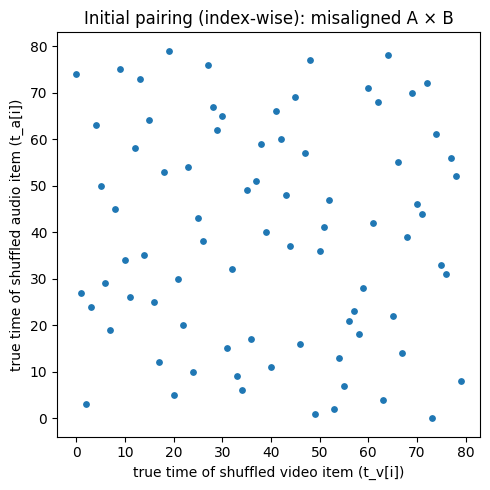

In [7]:
# --- Initial misalignment scatter: pair items by index (i -> i), which is wrong after independent shuffles ---
import matplotlib.pyplot as plt
import numpy as np

init_x = t_v.copy()
init_y = t_a.copy()

plt.figure(figsize=(5,5))
plt.scatter(init_x, init_y, s=15)
plt.xlabel("true time of shuffled video item (t_v[i])")
plt.ylabel("true time of shuffled audio item (t_a[i])")
plt.title("Initial pairing (index-wise): misaligned A × B")
plt.tight_layout()
plt.show()

## 2) Train timestamp predictors $f$ and $g$

In [8]:
Vt = torch.tensor(V_shuf, device=device)
At = torch.tensor(A_shuf, device=device)
tv = torch.tensor(t_v, device=device)
ta = torch.tensor(t_a, device=device)

class TimeClassifier(nn.Module):
    def __init__(self, d_in, T):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 128),
            nn.ReLU(),
            nn.Linear(128, T)
        )
    def forward(self, x):
        return self.net(x)

f = TimeClassifier(Vt.shape[1], T).to(device)
g = TimeClassifier(At.shape[1], T).to(device)

opt = torch.optim.Adam(list(f.parameters()) + list(g.parameters()), lr=2e-3, weight_decay=1e-4)

def acc(logits, y):
    return (logits.argmax(dim=-1) == y).float().mean().item()

for ep in range(1, 201):
    f.train(); g.train()
    logits_v = f(Vt)
    logits_a = g(At)
    loss = F.cross_entropy(logits_v, tv) + F.cross_entropy(logits_a, ta)
    opt.zero_grad(); loss.backward(); opt.step()

    if ep in [1, 5, 10, 25, 50, 100, 200]:
        f.eval(); g.eval()
        with torch.no_grad():
            av = acc(f(Vt), tv)
            aa = acc(g(At), ta)
        print(f"ep={ep:03d} loss={loss.item():.3f} acc_v={av:.3f} acc_a={aa:.3f}")


ep=001 loss=8.816 acc_v=0.038 acc_a=0.050
ep=005 loss=7.969 acc_v=0.350 acc_a=0.412
ep=010 loss=6.912 acc_v=0.825 acc_a=0.800
ep=025 loss=3.291 acc_v=0.988 acc_a=0.988
ep=050 loss=0.262 acc_v=1.000 acc_a=1.000
ep=100 loss=0.031 acc_v=1.000 acc_a=1.000
ep=200 loss=0.012 acc_v=1.000 acc_a=1.000


Soft pullback (approximate equality) and why Hungarian appears

In practice, f and g are uncertain: they output distributions over C, not exact timestamps.
So we relax equality f(v)=g(a) to “agreement in distribution.”

Define the compatibility weight

$ w(i,j) \;=\; \sum_{t\in C} p(t\mid v_i)\,p(t\mid a_j)
\;=\; \langle p(\cdot\mid v_i),\; p(\cdot\mid a_j)\rangle.$

	•	If the distributions agree, w(i,j) is large.
	•	If they disagree, w(i,j) is small.

Now we want a global alignment (a bijection between the T video items and T audio items) that maximizes total agreement:

$\max_{\text{matching }M} \sum_{(i,j)\in M} w(i,j)$.

This is exactly the assignment problem, which we solve with the Hungarian algorithm (linear_sum_assignment), using cost =-w.

This “soft pullback” is an approximate universal construction: it produces the best matching that maximizes commutativity in expectation.

## 3) Build the pullback alignment (hard and soft)

In [9]:
f.eval(); g.eval()
with torch.no_grad():
    Pv = F.softmax(f(Vt), dim=-1).cpu().numpy()  # (T, T)
    Pa = F.softmax(g(At), dim=-1).cpu().numpy()  # (T, T)

# Hard pullback (bucket by argmax time)
t_hat_v = Pv.argmax(axis=1)
t_hat_a = Pa.argmax(axis=1)

a_bucket = {}
for j, tj in enumerate(t_hat_a):
    a_bucket.setdefault(int(tj), []).append(j)

hard_pairs = []
used_a = set()
for i, ti in enumerate(t_hat_v):
    for j in a_bucket.get(int(ti), []):
        if j not in used_a:
            used_a.add(j)
            hard_pairs.append((i, j))
            break

hard_acc = sum(1 for i,j in hard_pairs if t_v[i] == t_a[j]) / max(1, len(hard_pairs))
print("Hard pullback pairs:", len(hard_pairs), "hard alignment acc:", hard_acc)

# Soft pullback via distribution overlap + Hungarian assignment
# W[i,j] = <p(t|v_i), p(t|a_j)>  measures agreement in C; higher is better
W = Pv @ Pa.T  # compatibility
row_ind, col_ind = linear_sum_assignment(-W)
soft_pairs = list(zip(row_ind.tolist(), col_ind.tolist()))
soft_acc = sum(1 for i,j in soft_pairs if t_v[i] == t_a[j]) / len(soft_pairs)
print("Soft pullback (Hungarian) acc:", soft_acc)


Hard pullback pairs: 80 hard alignment acc: 1.0
Soft pullback (Hungarian) acc: 1.0


## 4) Visualize alignment quality

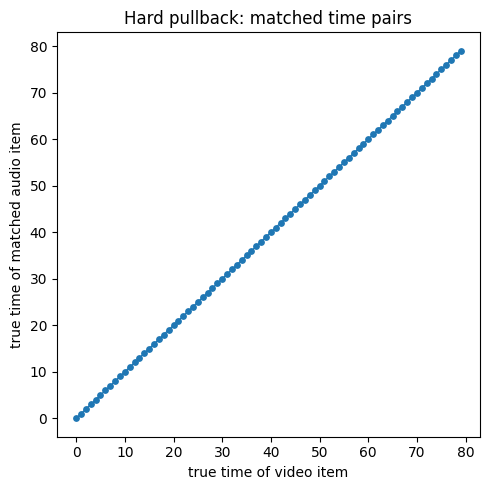

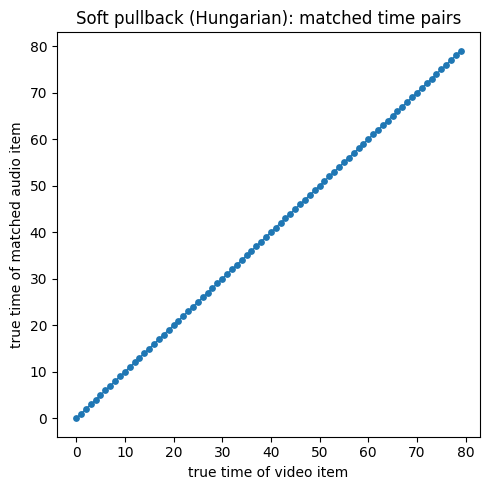

Saved: hard_pullback_scatter.{pdf,png}, soft_pullback_scatter.{pdf,png}


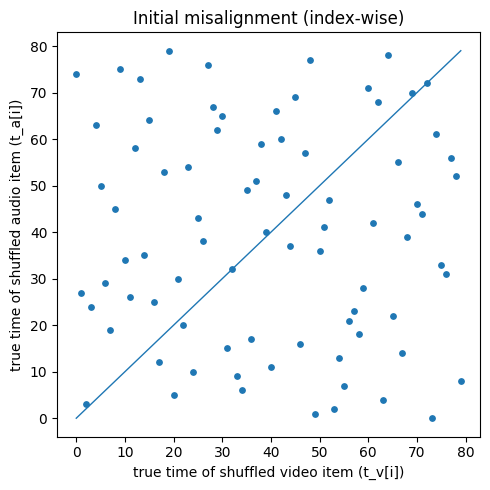

In [10]:
# --- Final aligned scatters (hard + soft) and save for slides ---
import matplotlib.pyplot as plt
import numpy as np

hard_x = np.array([t_v[i] for i,j in hard_pairs], dtype=np.int64)
hard_y = np.array([t_a[j] for i,j in hard_pairs], dtype=np.int64)

soft_x = np.array([t_v[i] for i,j in soft_pairs], dtype=np.int64)
soft_y = np.array([t_a[j] for i,j in soft_pairs], dtype=np.int64)

plt.figure(figsize=(5,5))
plt.scatter(hard_x, hard_y, s=15)
plt.plot([0, T-1], [0, T-1], linewidth=1)
plt.xlabel("true time of video item")
plt.ylabel("true time of matched audio item")
plt.title("Hard pullback: matched time pairs")
plt.tight_layout()
plt.savefig("hard_pullback_scatter.pdf", bbox_inches="tight")
plt.savefig("hard_pullback_scatter.png", bbox_inches="tight", dpi=200)
plt.show()

plt.figure(figsize=(5,5))
plt.scatter(soft_x, soft_y, s=15)
plt.plot([0, T-1], [0, T-1], linewidth=1)
plt.xlabel("true time of video item")
plt.ylabel("true time of matched audio item")
plt.title("Soft pullback (Hungarian): matched time pairs")
plt.tight_layout()
plt.savefig("soft_pullback_scatter.pdf", bbox_inches="tight")
plt.savefig("soft_pullback_scatter.png", bbox_inches="tight", dpi=200)
plt.show()

print("Saved: hard_pullback_scatter.{pdf,png}, soft_pullback_scatter.{pdf,png}")

plt.figure(figsize=(5,5))
plt.scatter(t_v, t_a, s=15)
plt.plot([0, T-1], [0, T-1], linewidth=1)
plt.xlabel("true time of shuffled video item (t_v[i])")
plt.ylabel("true time of shuffled audio item (t_a[i])")
plt.title("Initial misalignment (index-wise)")
plt.tight_layout()
plt.savefig("initial_misalignment_scatter.pdf", bbox_inches="tight")
plt.savefig("initial_misalignment_scatter.png", bbox_inches="tight", dpi=200)
plt.show()

## 5) Takeaway
- Pullback aligns two modalities by gluing them over timestamps.
- Hard pullback uses equality in $C$ (argmax).
- Soft pullback uses approximate equality and solves a global matching.
- Same pattern applies to LLMs by choosing an interface object $C$ (logits, hidden states, or predicate truth values).
